In [112]:
import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from copy import deepcopy

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense

import sys
sys.path.insert(0, '../configs/')
sys.path.insert(0, '../src/')

import utils
import test_config as conf
import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
Xvar = conf.variables['xvar']
yvar = conf.variables['yvar']
frac = 0.7    #If missing data > 48 %, find a new test window

path_to_package = '/Users/pluto/Desktop/bag/tutoring/atbin/imputation/package/'

# ----- Data preprocessing
df = pd.read_csv(path_to_package + 'data_out/Gingin_L4_processed.csv', parse_dates=['DateTime'])

test_df_, train_df_ = train_test_split.layer_train_test_set(df, conf, missing_frac=frac)

143:layer_train_test_set:Data used only between dates 2013-03-03 00:00:00 and 2013-07-31 23:30:00 (both inclusive).
165:layer_train_test_set:Test interval start: 2013-03-20 22:00:00 end: 2013-04-19 22:00:00


Number of missing days 30 > 21 = (0.7*30).
Gap condition not satisfied.


In [114]:
np.minimum(test_df_[yvar].min(), train_df_[yvar].min())

-36.700340106686504

In [115]:
#train_df_.fillna(-99, inplace=True)

In [116]:
# Combining data frame for scaling
full_df = pd.concat([train_df_, test_df_])
ymean, ystd = full_df[yvar].mean(), full_df[yvar].std()
yvar_val = full_df[yvar].values
yvar_val = (yvar_val - ymean)/ystd
yscale = (ymean, ystd)

setrank = full_df['Set_rank'].values
dtime = full_df['DateTime'].values

scaler = StandardScaler()
full_df = scaler.fit_transform(full_df[Xvar])
full_df = pd.DataFrame.from_records(full_df, columns=Xvar)
full_df['Set_rank'] = setrank
full_df['DateTime'] = dtime
full_df[yvar] = yvar_val

full_df.sort_values('DateTime', inplace=True)

# --------- Training
# Layer 1 training parameters
N_FOLDS = 3
N_CALLS = 51
THRESHOLD = 0.05

# List of models

model_library = {
    'LGBM':
        {
            'params_space': [Integer(2, 10, name='num_leaves'),
                             Categorical(['regression'], name="objective"),
                             Integer(2, 10, name='min_data_in_leaf'),
                             Real(10 ** -4, 10 ** 0, "uniform", name='learning_rate'),
                             Integer(100, 500, name='n_estimators')],
            'model_instance': lgb.LGBMRegressor(),
            'data': 'subset1'},

    'RFE':
        {
            'params_space': [Integer(2, 25, name='max_depth'),
                             Integer(2, 15, name='min_samples_leaf'),
                             Integer(2, 15, name='min_samples_split'),
                             Integer(100, 500, name='n_estimators')],
            'model_instance': RandomForestRegressor(),
            'data': 'subset2'
        },

    'SVM':
        {
            'params_space': [Integer(2, 6, name='degree'),
                             Categorical(['scale'], name='gamma'),
                             Categorical(['rbf', 'poly', 'sigmoid'], name='kernel'),
                             Real(1, 100, "uniform", name='C')],
            'model_instance': SVR(),
            'data': 'subset3'
        },

    'GP':
        {
            'params_space': [Categorical([None], name='kernel'),
                             Categorical(['fmin_l_bfgs_b', 'adam'], name='optimizer'),
                             Real(1e-4, 1, "uniform", name='alpha')],
            'model_instance': GaussianProcessRegressor(),
            'data': 'subset4'
        },

    'ANN':
        {
            'params_space': [Integer(2, 20, name='hidden_layer_sizes'),
                             Categorical(['relu'], name='activation'),
                             Categorical(['adam', 'lbfgs'], name='solver'),
                             Real(1e-4, 1, "uniform", name='alpha'),
                             Real(1e-3, 0.1, "uniform", name='learning_rate_init'),
                             Categorical(['constant', 'adaptive'], name='learning_rate')],
            'model_instance': MLPRegressor(),
            'data': 'subset5'
        },

    'LASSO':
        {'params_space': None, 'model_instance': Lasso(), 'data': 'subset6'}
}

solvers_layer1 = conf.solvers_layer1
solvers_layer2 = conf.solvers_layer2

In [117]:
test_filter = (full_df['Set_rank']=='test')
# ------- Single model run ------
Xtrain_bothlayers = full_df.loc[(full_df['Set_rank'] != 'test') & (~full_df[yvar].isna()), Xvar]
ytrain_bothlayers = full_df.loc[(full_df['Set_rank'] != 'test') & (~full_df[yvar].isna()), yvar]

### RFE with yvar = NAN removed

In [118]:
for key in solvers_layer2:
    label = f'val_Layer2_single_{key}'
    val = deepcopy(model_library[key])
    reg = val['model_instance']
    params_space = val['params_space']


    # Bayesian opt. part
    @use_named_args(params_space)
    def jth_objective(**params):
        cls = reg.set_params(**params)
        return utils.objective_core(cls, Xtrain_bothlayers, ytrain_bothlayers,
                                    label, yscale,
                                    nfolds=N_FOLDS, **params)


    res = gp_minimize(jth_objective, params_space, n_calls=N_CALLS, random_state=0)
    "Best score=%.4f" % res.fun

    # Generating final optimized model instance
    print("Optimal parameters")
    params = {}
    for param, value in zip(params_space, res.x):
        print(f"Param: {param.name}, value: {value}")
        params[param.name] = value

    jth_model = reg.set_params(**params)
    jth_model.fit(Xtrain_bothlayers.values, ytrain_bothlayers.values)

    # Model instance for ensemble
    model_library[key]['model_instance_single'] = jth_model


# Final SINGLE prediction on Xtest
X_test = full_df.loc[test_filter, Xvar]
y_test = full_df.loc[test_filter, yvar]

# Prediction
for key in solvers_layer2:
    val = model_library[key]
    cls = val[f'model_instance_single']
    y_predicted_test = cls.predict(X_test)
    full_df.loc[test_filter, yvar + f'_predicted_test_single_{key}'] =  y_predicted_test * ystd + ymean

------ Sampling new data point ------
RMSE: 0.550, R^2: 0.323, MBE: 0.029
RMSE: 0.535, R^2: 0.340, MBE: 0.001
RMSE: 0.555, R^2: 0.311, MBE: -0.034
Params: {'num_leaves': 7, 'objective': 'regression', 'min_data_in_leaf': 9, 'learning_rate': 0.8472670136102473, 'n_estimators': 349, 'n_jobs': -1}
Score: 0.5464260565844287
------ Sampling new data point ------
RMSE: 0.446, R^2: 0.444, MBE: -0.002
RMSE: 0.509, R^2: 0.394, MBE: 0.013
RMSE: 0.468, R^2: 0.413, MBE: -0.009
Params: {'num_leaves': 5, 'objective': 'regression', 'min_data_in_leaf': 2, 'learning_rate': 0.27272902895065526, 'n_estimators': 291, 'n_jobs': -1}
Score: 0.4743312255350361
------ Sampling new data point ------
RMSE: 0.596, R^2: 0.261, MBE: -0.002
RMSE: 0.550, R^2: 0.312, MBE: 0.009
RMSE: 0.564, R^2: 0.287, MBE: 0.003
Params: {'num_leaves': 8, 'objective': 'regression', 'min_data_in_leaf': 5, 'learning_rate': 0.836095155661024, 'n_estimators': 235, 'n_jobs': -1}
Score: 0.5699231238328979
------ Sampling new data point -----

------ Sampling new data point ------
RMSE: 0.458, R^2: 0.452, MBE: 0.004
RMSE: 0.449, R^2: 0.457, MBE: 0.005
RMSE: 0.454, R^2: 0.445, MBE: -0.013
Params: {'num_leaves': 10, 'objective': 'regression', 'min_data_in_leaf': 5, 'learning_rate': 0.1714531380329097, 'n_estimators': 100, 'n_jobs': -1}
Score: 0.45351300146743556
------ Sampling new data point ------
RMSE: 0.385, R^2: 0.544, MBE: -0.027
RMSE: 0.441, R^2: 0.468, MBE: 0.042
RMSE: 0.508, R^2: 0.401, MBE: -0.014
Params: {'num_leaves': 2, 'objective': 'regression', 'min_data_in_leaf': 10, 'learning_rate': 0.2861850062191599, 'n_estimators': 100, 'n_jobs': -1}
Score: 0.4446446206533376
------ Sampling new data point ------
RMSE: 0.474, R^2: 0.388, MBE: 0.027
RMSE: 0.458, R^2: 0.432, MBE: -0.018
RMSE: 0.518, R^2: 0.394, MBE: -0.005
Params: {'num_leaves': 3, 'objective': 'regression', 'min_data_in_leaf': 4, 'learning_rate': 0.5552135266007312, 'n_estimators': 500, 'n_jobs': -1}
Score: 0.4835038132211138
------ Sampling new data point -

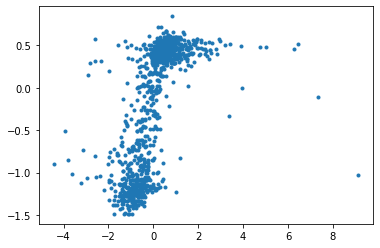

In [119]:
plt.plot(y_test, y_predicted_test,  '.')

### LSTM with yvar = NAN removed

In [120]:
# LSTM -- Single
NSTEPS = 5
NFEATURES = Xtrain_bothlayers.shape[1]

# convert into input/output sequences
dataset_train = np.column_stack((Xtrain_bothlayers, ytrain_bothlayers))
dataset_trainX, dataset_trainy = utils.split_sequences(dataset_train, NSTEPS)
print(dataset_trainX.shape, dataset_trainy.shape)

# define model
model_lstm = Sequential()
#model_lstm.add(LSTM(5, input_shape=(NSTEPS, NFEATURES), activation='relu', dropout=0.5, recurrent_dropout=0.5))
model_lstm.add(Bidirectional(LSTM(5, input_shape=(NSTEPS, NFEATURES), activation='relu', dropout=0.5, recurrent_dropout=0.5)))
#model_lstm.add(Dense(3, kernel_initializer='normal', activation='relu'))
model_lstm.add(Dense(1, activation='linear'))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
history = model_lstm.fit(dataset_trainX, dataset_trainy,
                            validation_split=0.5, shuffle=False,
                            epochs=50, batch_size=32, verbose=2)

dataset_test = np.column_stack((X_test, y_test))
dataset_testX, dataset_testy = utils.split_sequences(dataset_test, n_steps=NSTEPS)
yhat_test = model_lstm.predict(dataset_testX, verbose=0)

metric_lstm = utils.diagnostic_stats(dataset_testy*ystd + ymean,
                                     yhat_test.squeeze()*ystd + ymean)

yhat_test = np.concatenate((np.array([np.nan]*(NSTEPS-1)), yhat_test.squeeze()))

full_df.loc[test_filter,
            yvar + f'_predicted_test_single_LSTM'] = yhat_test * ystd + ymean

utils.SCORES['Layer2' + '_' + 'LSTM' + '_' + 'single'] = {'rmse':metric_lstm[0],
                                                          'rsqr':metric_lstm[1],
                                                          'mbe':metric_lstm[2],
                                                          'corr':metric_lstm[3],
                                                          'stddev':metric_lstm[4]}

(3822, 5, 9) (3822,)
Train on 1911 samples, validate on 1911 samples
Epoch 1/50
 - 6s - loss: 1.0553 - val_loss: 0.8907
Epoch 2/50
 - 1s - loss: 0.8214 - val_loss: 0.8239
Epoch 3/50
 - 1s - loss: 0.7427 - val_loss: 0.8080
Epoch 4/50
 - 1s - loss: 0.7280 - val_loss: 0.7958
Epoch 5/50
 - 1s - loss: 0.7113 - val_loss: 0.7851
Epoch 6/50
 - 1s - loss: 0.6772 - val_loss: 0.7656
Epoch 7/50
 - 1s - loss: 0.6433 - val_loss: 0.7529
Epoch 8/50
 - 1s - loss: 0.6183 - val_loss: 0.7429
Epoch 9/50
 - 1s - loss: 0.6363 - val_loss: 0.7376
Epoch 10/50
 - 1s - loss: 0.6196 - val_loss: 0.7320
Epoch 11/50
 - 1s - loss: 0.5995 - val_loss: 0.7224
Epoch 12/50
 - 1s - loss: 0.6005 - val_loss: 0.7152
Epoch 13/50
 - 1s - loss: 0.5948 - val_loss: 0.7046
Epoch 14/50
 - 1s - loss: 0.5896 - val_loss: 0.7018
Epoch 15/50
 - 1s - loss: 0.5862 - val_loss: 0.6947
Epoch 16/50
 - 1s - loss: 0.5655 - val_loss: 0.6899
Epoch 17/50
 - 1s - loss: 0.5710 - val_loss: 0.6880
Epoch 18/50
 - 1s - loss: 0.5844 - val_loss: 0.6824
Epoc

In [121]:
# ---------- Summary stats -------------------
ytest = full_df.loc[test_filter, yvar] * ystd + ymean

for key in solvers_layer2:
    for j in ['single']:
        ytest_predicted = full_df.loc[test_filter, yvar + f'_predicted_test_{j}_{key}']

        print('Layer2', key, j)
        ametric = utils.diagnostic_stats(ytest, ytest_predicted)
        #print(ascore)
        all_scores = {}
        for k, metric_name in enumerate(['rmse', 'rsqr', 'mbe', 'corr', 'stddev']):
            all_scores[metric_name] = ametric[k]

        utils.SCORES['Layer2' + '_' + key + '_' + j] = all_scores

score_df = pd.DataFrame.from_dict(utils.SCORES).T.round(3)

Layer2 LGBM single
RMSE: 2.938, R^2: 0.398, MBE: 0.586


In [122]:
score_df

,rmse,rsqr,mbe,corr,stddev
val_Layer2_single_LGBM,0.457,0.442,0.003,0.665,0.435
Layer2_LSTM_single,2.944,0.386,0.456,0.621,2.462
Layer2_LGBM_single,2.938,0.398,0.586,0.631,2.550


In [111]:
score_df

,rmse,rsqr,mbe,corr,stddev
val_Layer2_single_LGBM,0.457,0.442,0.003,0.665,0.435
Layer2_LSTM_single,2.944,0.386,0.455,0.621,2.460
Layer2_LGBM_single,2.938,0.398,0.586,0.631,2.550


### RFE with -10

In [61]:
# ------- Single model run ------
Xtrain_bothlayers = full_df.loc[(full_df['Set_rank'] != 'test'), Xvar]
ytrain_bothlayers = full_df.loc[(full_df['Set_rank'] != 'test'), yvar].fillna(-99)

In [62]:

for key in solvers_layer2:
    label = f'val_Layer2_single_{key}'
    val = deepcopy(model_library[key])
    reg = val['model_instance']
    params_space = val['params_space']


    # Bayesian opt. part
    @use_named_args(params_space)
    def jth_objective(**params):
        cls = reg.set_params(**params)
        return utils.objective_core(cls, Xtrain_bothlayers, ytrain_bothlayers,
                                    label, yscale,
                                    nfolds=N_FOLDS, **params)


    res = gp_minimize(jth_objective, params_space, n_calls=N_CALLS, random_state=0)
    "Best score=%.4f" % res.fun

    # Generating final optimized model instance
    print("Optimal parameters")
    params = {}
    for param, value in zip(params_space, res.x):
        print(f"Param: {param.name}, value: {value}")
        params[param.name] = value

    jth_model = reg.set_params(**params)
    jth_model.fit(Xtrain_bothlayers.values, ytrain_bothlayers.values)

    # Model instance for ensemble
    model_library[key]['model_instance_single'] = jth_model


# Final SINGLE prediction on Xtest
X_test = full_df.loc[test_filter, Xvar]
y_test = full_df.loc[test_filter, yvar]

# Prediction
for key in solvers_layer2:
    val = model_library[key]
    cls = val[f'model_instance_single']
    y_predicted_test = cls.predict(X_test)
    full_df.loc[test_filter, yvar + f'_predicted_test_single_{key}'] =  y_predicted_test * ystd + ymean

Finished loading model, total used 100 iterations
------ Sampling new data point ------
RMSE: 14.646, R^2: 0.756, MBE: 0.057
RMSE: 14.913, R^2: 0.739, MBE: -0.113
RMSE: 14.874, R^2: 0.750, MBE: 0.129
Params: {'num_leaves': 7, 'objective': 'regression', 'min_data_in_leaf': 9, 'learning_rate': 0.8472670136102473, 'n_estimators': 349, 'n_jobs': -1}
Score: 14.81112242424991
------ Sampling new data point ------
RMSE: 12.665, R^2: 0.806, MBE: -0.101
RMSE: 12.353, R^2: 0.814, MBE: 0.190
RMSE: 13.198, R^2: 0.791, MBE: -0.253
Params: {'num_leaves': 5, 'objective': 'regression', 'min_data_in_leaf': 2, 'learning_rate': 0.27272902895065526, 'n_estimators': 291, 'n_jobs': -1}
Score: 12.738494100851186
------ Sampling new data point ------
RMSE: 15.553, R^2: 0.718, MBE: 0.612
RMSE: 14.773, R^2: 0.751, MBE: 0.610
RMSE: 14.625, R^2: 0.755, MBE: -0.498
Params: {'num_leaves': 8, 'objective': 'regression', 'min_data_in_leaf': 5, 'learning_rate': 0.836095155661024, 'n_estimators': 235, 'n_jobs': -1}
Scor

------ Sampling new data point ------
RMSE: 13.124, R^2: 0.794, MBE: 0.451
RMSE: 11.567, R^2: 0.837, MBE: -0.307
RMSE: 11.967, R^2: 0.828, MBE: -0.207
Params: {'num_leaves': 10, 'objective': 'regression', 'min_data_in_leaf': 9, 'learning_rate': 0.21738140108138854, 'n_estimators': 500, 'n_jobs': -1}
Score: 12.219510425019507
------ Sampling new data point ------
RMSE: 12.386, R^2: 0.817, MBE: -0.172
RMSE: 12.348, R^2: 0.813, MBE: 0.419
RMSE: 11.702, R^2: 0.834, MBE: 0.182
Params: {'num_leaves': 10, 'objective': 'regression', 'min_data_in_leaf': 2, 'learning_rate': 0.1210757098253665, 'n_estimators': 500, 'n_jobs': -1}
Score: 12.1452858689052
------ Sampling new data point ------
RMSE: 12.761, R^2: 0.805, MBE: -0.286
RMSE: 12.639, R^2: 0.806, MBE: 0.056
RMSE: 12.578, R^2: 0.808, MBE: 0.219
Params: {'num_leaves': 10, 'objective': 'regression', 'min_data_in_leaf': 2, 'learning_rate': 0.11537202609750248, 'n_estimators': 500, 'n_jobs': -1}
Score: 12.659437213960532
------ Sampling new data

Optimal parameters
Param: num_leaves, value: 10
Param: objective, value: regression
Param: min_data_in_leaf, value: 10
Param: learning_rate, value: 0.0872621163130894
Param: n_estimators, value: 500


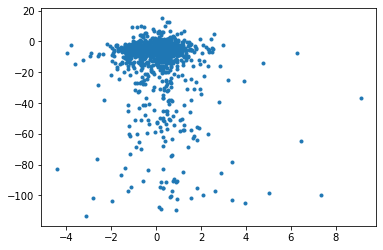

In [63]:
plt.plot(y_test, y_predicted_test,  '.')

### LSTM with -10

In [64]:
ystd2, ymean2 = ytrain_bothlayers.std(), ytrain_bothlayers.mean()
ytrain_bothlayers = (ytrain_bothlayers - ymean2)/ystd2

In [65]:
# LSTM -- Single
NSTEPS = 5
NFEATURES = Xtrain_bothlayers.shape[1]

# convert into input/output sequences
dataset_train = np.column_stack((Xtrain_bothlayers, ytrain_bothlayers))
dataset_trainX, dataset_trainy = utils.split_sequences(dataset_train, NSTEPS)
print(dataset_trainX.shape, dataset_trainy.shape)

# define model
model_lstm = Sequential()
model_lstm.add(LSTM(5, input_shape=(NSTEPS, NFEATURES), activation='relu', dropout=0.5, recurrent_dropout=0.5))
#model_lstm.add(Dense(3, kernel_initializer='normal', activation='relu'))
model_lstm.add(Dense(1, activation='linear'))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
history = model_lstm.fit(dataset_trainX, dataset_trainy,
                            validation_split=0.5, shuffle=False,
                            epochs=50, batch_size=32, verbose=2)

dataset_test = np.column_stack((X_test, y_test))
dataset_testX, dataset_testy = utils.split_sequences(dataset_test, n_steps=NSTEPS)
yhat_test = model_lstm.predict(dataset_testX, verbose=0)

metric_lstm = utils.diagnostic_stats(dataset_testy*ystd + ymean,
                                     yhat_test.squeeze()*ystd + ymean)

yhat_test = np.concatenate((np.array([np.nan]*(NSTEPS-1)), yhat_test.squeeze()))

full_df.loc[test_filter,
            yvar + f'_predicted_test_single_LSTM'] = yhat_test * ystd + ymean

utils.SCORES['Layer2' + '_' + 'LSTM' + '_' + 'single'] = {'rmse':metric_lstm[0],
                                                          'rsqr':metric_lstm[1],
                                                          'mbe':metric_lstm[2],
                                                          'corr':metric_lstm[3],
                                                          'stddev':metric_lstm[4]}

(5803, 5, 9) (5803,)
Train on 2901 samples, validate on 2902 samples
Epoch 1/50
 - 3s - loss: 5.1668 - val_loss: 0.9115
Epoch 2/50
 - 1s - loss: 2.8968 - val_loss: 0.8765
Epoch 3/50
 - 1s - loss: 1.9185 - val_loss: 0.8662
Epoch 4/50
 - 1s - loss: 1.4612 - val_loss: 0.8673
Epoch 5/50
 - 1s - loss: 1.2823 - val_loss: 0.8690
Epoch 6/50
 - 1s - loss: 1.1490 - val_loss: 0.8706
Epoch 7/50
 - 1s - loss: 1.0958 - val_loss: 0.8706
Epoch 8/50
 - 1s - loss: 1.0319 - val_loss: 0.8688
Epoch 9/50
 - 1s - loss: 0.9848 - val_loss: 0.8637
Epoch 10/50
 - 1s - loss: 0.9522 - val_loss: 0.8585
Epoch 11/50
 - 1s - loss: 0.9595 - val_loss: 0.8534
Epoch 12/50
 - 1s - loss: 0.9397 - val_loss: 0.8460
Epoch 13/50
 - 1s - loss: 0.9281 - val_loss: 0.8390
Epoch 14/50
 - 1s - loss: 0.9018 - val_loss: 0.8321
Epoch 15/50
 - 1s - loss: 0.8912 - val_loss: 0.8247
Epoch 16/50
 - 1s - loss: 0.9035 - val_loss: 0.8175
Epoch 17/50
 - 1s - loss: 0.8747 - val_loss: 0.8105
Epoch 18/50
 - 1s - loss: 0.8953 - val_loss: 0.8046
Epoc

In [66]:
solvers_layer2

['LGBM']

In [67]:
# ---------- Summary stats -------------------
ytest = full_df.loc[test_filter, yvar] * ystd + ymean

for key in solvers_layer2:
    for j in ['single']:
        ytest_predicted = full_df.loc[test_filter, yvar + f'_predicted_test_{j}_{key}']

        print('Layer2', key, j)
        ametric = utils.diagnostic_stats(ytest, ytest_predicted)
        #print(ascore)
        all_scores = {}
        for k, metric_name in enumerate(['rmse', 'rsqr', 'mbe', 'corr', 'stddev']):
            all_scores[metric_name] = ametric[k]

        utils.SCORES['Layer2' + '_' + key + '_' + j] = all_scores

score_df2 = pd.DataFrame.from_dict(utils.SCORES).T.round(3)

Layer2 LGBM single
RMSE: 1077.309, R^2: 0.016, MBE: 561.186


In [68]:
# With -10
score_df2

,rmse,rsqr,mbe,corr,stddev
val_Layer2_single_LGBM,15.701,0.701,-0.008,0.838,23.832
Layer2_LSTM_single,53.046,0.022,19.152,-0.148,9.553
Layer2_LGBM_single,1077.309,0.016,561.186,-0.126,912.497


In [33]:
# with nan removed
score_df

,rmse,rsqr,mbe,corr,stddev
val_Layer2_single_LGBM,0.447,0.465,0.000,0.682,0.409
Layer2_LSTM_single,3.002,0.364,0.402,0.603,1.911
Layer2_LGBM_single,2.947,0.398,0.622,0.631,2.560
